<a href="https://colab.research.google.com/github/inkestonine/cancer-patient-classifier/blob/main/BIOS534_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***BIOS 534 - HW2 - Shifan Yan***

In [ ]:
import torch
import numpy as np
print(f"pytorch version: {torch.__version__}")
print(f"numpy version: {np.__version__}")

pytorch version: 2.2.1+cu121
numpy version: 1.25.2


# 1. Tensor operations in PyTorch

## a. Create a 2D tensor (elements drawn from standard normal) and then visualize its dimension. Add a dimension of size 1 inserted at dimension 1.

In [ ]:
# create a 2d tensor from std nor
tensor = torch.from_numpy(np.random.randn(2, 2))
print("2D tensor:", tensor)
# visualize the dim
print("The dimension of 2D tensor:",tensor.shape)
# add a dimension of size 1 inserted at dimension 1
tensor = tensor.unsqueeze(1)
print("3D tensor:", tensor)

2D tensor: tensor([[ 0.8192, -0.6385],
        [ 0.0354, -0.8814]], dtype=torch.float64)
The dimension of 2D tensor: torch.Size([2, 2])
3D tensor: tensor([[[ 0.8192, -0.6385]],

        [[ 0.0354, -0.8814]]], dtype=torch.float64)


## b. Remove the extra dimension you just added to the previous tensor.

In [ ]:
tensor = tensor.squeeze(1)
tensor.shape

torch.Size([2, 2])

## c. Create a random tensor of shape 5x3 drawn from the standard normal distribution.

In [ ]:
# create a tensor of 5*3 from std nor
tensor = torch.from_numpy(np.random.randn(5, 3))
tensor

tensor([[ 0.4394,  1.1920,  0.6703],
        [-0.2128,  1.6250,  2.2671],
        [ 0.1999, -1.3066, -0.5876],
        [-1.0069, -0.6051, -1.2374],
        [-0.1764,  1.1277, -0.9946]], dtype=torch.float64)

## d. Create a random tensor of size (3,1) and horizontally stack four copies together. (the shape of the resulting tensor is (3,4)).

In [ ]:
tensor = torch.rand(size=(3,1))
print(tensor)
torch.cat([tensor, tensor, tensor, tensor], dim=1)

tensor([[0.3963],
        [0.0558],
        [0.7638]])


tensor([[0.3963, 0.3963, 0.3963, 0.3963],
        [0.0558, 0.0558, 0.0558, 0.0558],
        [0.7638, 0.7638, 0.7638, 0.7638]])

# 2. Fully connected neural network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
# download the fashion mnist dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,transform=transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8109181.56it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 137604.15it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2493481.52it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4889555.48it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## a. Split 20% of the training set as validation set to monitor the training process. Set the seed to guarantee the reproducibility of the experiment. Report the number of samples in your training, validation and testing set.

In [ ]:
val_proportion = 0.2 # the proportion of samples to be used as validation set

random_seed = 20220215 # random seed for reproducibility

val_size = int(val_proportion*len(train_dataset))
train_size = len(train_dataset) - val_size
test_size = len(test_dataset)

print(f"number samples in train: {train_size}")
print(f"number samples in val: {val_size}")
print(f"number samples in test: {test_size}")

# further split the entire training set to the training and validation set
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset=train_dataset,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(random_seed))

number samples in train: 48000
number samples in val: 12000
number samples in test: 10000


In [ ]:
# t = [train_dataset[i][1] for i in range(10)]
# t

[8, 6, 9, 9, 6, 8, 1, 7, 9, 1]

## b. What is your assessment strategy?

To answer this, you may have to specify a fully connected neural network with different number of linear hidden layers (example for building FC network). The number of neurons in each hidden layer is by your decision. Try with different epochs. (at least three). What is the optimal parameters in your case, please report the results in a table.

The network architecture is like following:

**input layer -> linear hidden layer (n) -> output layer**

In [67]:
# model training specifications
input_size = 784 # 28*28=784
num_classes = 10

learning_rate = 0.001
batch_size = 32
num_workers = 16
apply_dropout = False
dropout_p = 0.20

early_stopping_criteria= 5 # the tolerance level before terminating the training

# saved_model_fn = os.path.join('./model', "best_fcn_model.pt")

In [68]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class fcnn1(nn.Module):
  def __init__(self, input_size, num_classes, apply_dropout=False, dropout_p=0.50, apply_bn=False):
    super(fcnn1, self).__init__()

    self.fc1 = nn.Linear(input_size, 200)
    self.fc2 = nn.Linear(200, 50)
    self.fc3 = nn.Linear(50, num_classes)

  def forward(self, x):
    # hidden layer 1
    x = self.fc1(x)
    x = F.relu(x)
    # hidden layer 2
    x = self.fc2(x)
    x = F.relu(x)
    # output layer
    x = self.fc3(x)
    return x

class fcnn2(nn.Module):
  def __init__(self, input_size, num_classes, apply_dropout=False, dropout_p=0.50, apply_bn=False):
    super(fcnn2, self).__init__()

    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 16)
    self.fc4 = nn.Linear(16, num_classes)

  def forward(self, x):
    # hidden layer 1
    x = self.fc1(x)
    x = F.relu(x)
    # hidden layer 2
    x = self.fc2(x)
    x = F.relu(x)
    # hidden layer 3
    x = self.fc3(x)
    x = F.relu(x)
    # output layer
    x = self.fc4(x)
    return x

model_list = []
# collect the models
model_list.append(
    fcnn1(input_size=input_size,num_classes=num_classes,apply_dropout=apply_dropout,dropout_p=dropout_p)
)
model_list.append(
    fcnn2(input_size=input_size,num_classes=num_classes,apply_dropout=apply_dropout,dropout_p=dropout_p)
)

# print(model_list)


In [69]:
n = [10, 15, 20]

test_accuracy = []
for i in n:
  num_epochs = i
  print("number of epoch is: ",num_epochs)

  for j, clf in enumerate(model_list):
    model_id = f"model_{j}"
    print(f"Training {model_id}")

    # instantiate the loss and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

    train_state = {
      "train_loss": [],
      "train_acc": [],
      "val_loss": [],
      "val_acc": []
    }

    best_val_loss = float('inf')
    early_stopping_step = 0

    # set the path
    saved_model_fn = f"saved_model_{model_id}_epochs_{num_epochs}.pt"

    # training loop
    for epoch in range(num_epochs):
      running_train_loss = 0.0 # running loss for every 200 steps during training
      train_loss = 0.0 # accumulated training loss for the entire epoch
      num_train_samples = 0
      correct = 0
      clf.train() # switch to training mode
      # loop over batches
      for batch_idx, (images, targets) in enumerate(train_loader):

          # reshape the images to appropriate shape
          batch_size = images.shape[0]
          images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)

          # forward pass
          preds = clf(images)
          loss = criterion(preds, targets)

          # back prop
          optimizer.zero_grad() # clear the calculated gradients from the last batch
          loss.backward()

          # update model params
          optimizer.step()

          # evaluate performance for each batch
          running_train_loss += loss.item()
          train_loss += loss.item() * batch_size
          num_train_samples += batch_size
          _, pred_labels = torch.max(preds, dim=1) #(64, 10)
          correct += (pred_labels==targets).sum().item()

      epoch_train_loss= train_loss/num_train_samples
      epoch_train_acc= correct/num_train_samples

      # evaluate on the validation set every epoch
      clf.eval() # switch to evaluation mode
      val_loss = 0.0
      num_val_samples = 0
      correct = 0
      for images, targets in val_loader:
          # load and reshape the data
          batch_size = images.shape[0]
          images = images.reshape(batch_size, -1)

          # forward pass
          preds = clf(images)

          loss = criterion(preds, targets)
          val_loss += loss.item() * images.shape[0]
          num_val_samples += batch_size
          # calculate accuracy
          preds = clf(images) # shape: [batch, #classes]
          _, pred_labels = torch.max(preds, dim=1)
          correct += (pred_labels==targets).sum().item()
      epoch_val_loss= val_loss/num_val_samples
      epoch_val_acc= correct/num_val_samples
      # print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")

      # update train_state dict
      train_state['train_loss'].append(epoch_train_loss)
      train_state['train_acc'].append(epoch_train_acc)
      train_state['val_loss'].append(epoch_val_loss)
      train_state['val_acc'].append(epoch_val_acc)

    # saved best model
    torch.save(clf.state_dict(), saved_model_fn)
    print(f"Saved best model to {saved_model_fn}")

    # evaluate on testing set
    clf.eval()
    test_loss = 0.0
    num_test_samples = 0
    correct = 0
    for images, targets in test_loader:
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        preds = clf(images)
        loss = criterion(preds, targets)
        test_loss += loss.item() * images.shape[0]
        num_test_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")
    train_state_df = pd.DataFrame(train_state)
    # print(train_state_df.round(3))
    test_accuracy.append((i,clf,correct/num_test_samples))

number of epoch is:  10
Training model_0
Saved best model to saved_model_model_0_epochs_10.pt
testing loss: 0.349, testing accuracy: 88.170%
Training model_1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Saved best model to saved_model_model_1_epochs_10.pt
testing loss: 0.339, testing accuracy: 88.340%
number of epoch is:  15
Training model_0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Saved best model to saved_model_model_0_epochs_15.pt
testing loss: 0.388, testing accuracy: 89.200%
Training model_1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Saved best model to saved_model_model_1_epochs_15.pt
testing loss: 0.394, testing accuracy: 88.060%
number of epoch is:  20
Training model_0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Saved best model to saved_model_model_0_epochs_20.pt
testing loss: 0.534, testing accuracy: 88.820%
Training model_1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Saved best model to saved_model_model_1_epochs_20.pt
testing loss: 0.526, testing accuracy: 88.670%


In [70]:
pd.DataFrame(test_accuracy)

,0,1,2
0,10,"fcnn1(\n (fc1): Linear(in_features=784, out_f...",0.8817
1,10,"fcnn2(\n (fc1): Linear(in_features=784, out_f...",0.8834
2,15,"fcnn1(\n (fc1): Linear(in_features=784, out_f...",0.8920
3,15,"fcnn2(\n (fc1): Linear(in_features=784, out_f...",0.8806
4,20,"fcnn1(\n (fc1): Linear(in_features=784, out_f...",0.8882
5,20,"fcnn2(\n (fc1): Linear(in_features=784, out_f...",0.8867


**Based on the above table, I choose model with index of 3 (number of epochs=15, number of neurons in hidden layer = 200/50)**

## c. Please state the following reasoning for building your classifier: your choice of non-linear activation function (choice from 'sigmoid', 'relu', 'tanh', etc.) and the loss function for back-propagation.

Activation function: Relu for hidden layers (quick & effective), Softmax for output layers (already built into CrossEntropyLoss)

Loss function: CrossEntropyLoss (multiclassifier)

## d. Plot the learning curves of loss and report the testing accuracy. You can use the average loss from each epoch to plot it.

In [60]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()

testing loss: 0.417, testing accuracy: 88.420%


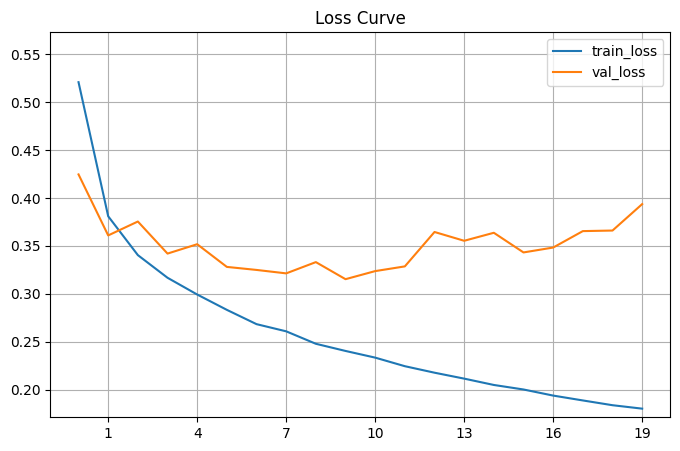

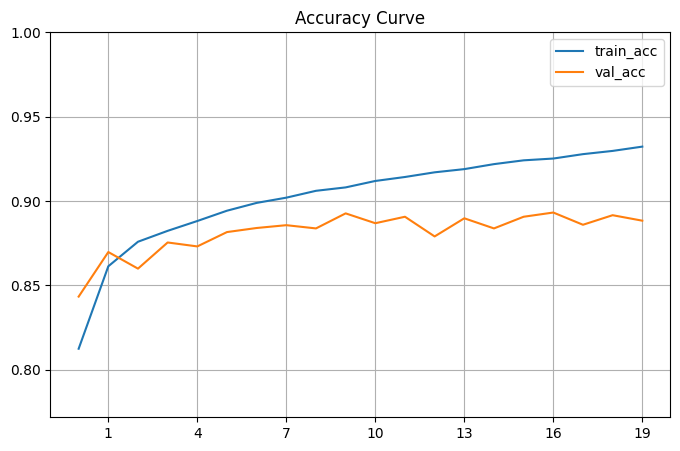

In [62]:
num_epochs = 15

clf = fcnn1(input_size=input_size,num_classes=num_classes,apply_dropout=apply_dropout,dropout_p=dropout_p)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
    }

best_val_loss = float('inf')

# training loop
for epoch in range(num_epochs):
  running_train_loss = 0.0
  train_loss = 0.0
  num_train_samples = 0
  correct = 0
  clf.train() # switch to training mode
  # loop over batches
  for batch_idx, (images, targets) in enumerate(train_loader):

    # reshape the images to appropriate shape
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)

    # forward pass
    preds = clf(images)
    loss = criterion(preds, targets)

    # back prop
    optimizer.zero_grad() # clear the calculated gradients from the last batch
    loss.backward()

    # update model params
    optimizer.step()

    # evaluate performance for each batch
    running_train_loss += loss.item()
    train_loss += loss.item() * batch_size
    num_train_samples += batch_size
    _, pred_labels = torch.max(preds, dim=1) #(64, 10)
    correct += (pred_labels==targets).sum().item()

  epoch_train_loss= train_loss/num_train_samples
  epoch_train_acc= correct/num_train_samples

  # evaluate on the validation set every epoch
  clf.eval() # switch to evaluation mode
  val_loss = 0.0
  num_val_samples = 0
  correct = 0
  for images, targets in val_loader:
    # load and reshape the data
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1)

    # forward pass
    preds = clf(images)

    loss = criterion(preds, targets)
    val_loss += loss.item() * images.shape[0]
    num_val_samples += batch_size
    # calculate accuracy
    preds = clf(images) # shape: [batch, #classes]
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
  epoch_val_loss= val_loss/num_val_samples
  epoch_val_acc= correct/num_val_samples

  # update train_state dict
  train_state['train_loss'].append(epoch_train_loss)
  train_state['train_acc'].append(epoch_train_acc)
  train_state['val_loss'].append(epoch_val_loss)
  train_state['val_acc'].append(epoch_val_acc)

# evaluate on testing set
clf.eval()
test_loss = 0.0
num_test_samples = 0
correct = 0
for images, targets in test_loader:
  batch_size = images.shape[0]
  images = images.reshape(batch_size, -1)
  preds = clf(images)
  loss = criterion(preds, targets)
  test_loss += loss.item() * images.shape[0]
  num_test_samples += batch_size
  # calculate accuracy
  preds = clf(images)
  _, pred_labels = torch.max(preds, dim=1)
  correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

train_state_df = pd.DataFrame(train_state)
# print(train_state_df.round(3))
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")

## e. Keep the same setting of hyper-parameters you have in your optimal model from problem 2. (number of neurons, non-linear activation function, optimizer, learning rate) and Answer the following questions:

### 1) Have you observed the overfitting problem in your model? Why does this happen?

Yes, the feature dataset is too small, and probably the model is correspondingly too complex.

### 2) Please add dropout with your preferred drop rate in your model. Show the difference of learning curves after you have experimented with your workaround in the model.

In [57]:
class fcnn3(nn.Module):
  def __init__(self, input_size, num_classes, apply_dropout=False, dropout_p=0.20, apply_bn=False):
    super(fcnn3, self).__init__()
    self.apply_dropout = True

    self.fc1 = nn.Linear(input_size, 200)
    self.fc2 = nn.Linear(200, 50)
    self.fc3 = nn.Linear(50, num_classes)
    self.dropout = nn.Dropout(p=dropout_p)

  def forward(self, x):
    # hidden layer 1
    x = self.fc1(x)
    x = F.relu(x)
    if self.apply_dropout: x = self.dropout(x)
    # hidden layer 2
    x = self.fc2(x)
    x = F.relu(x)
    if self.apply_dropout: x = self.dropout(x)
    # output layer
    x = self.fc3(x)
    return x

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


testing loss: 0.352, testing accuracy: 88.260%


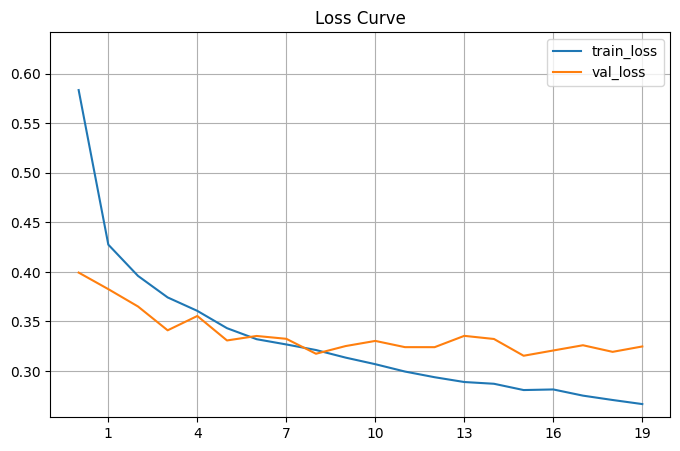

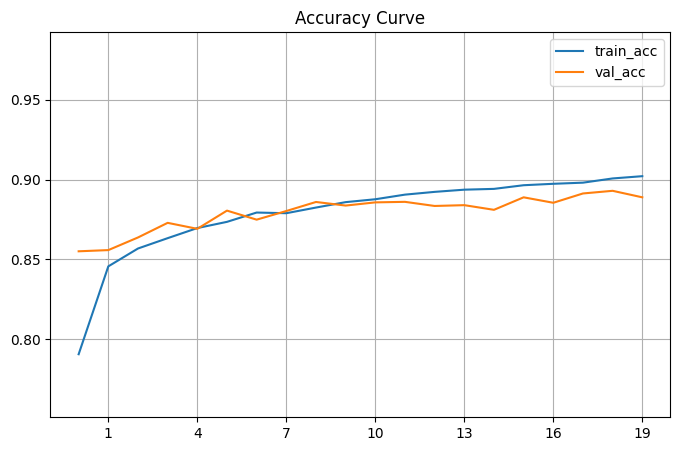

In [63]:
num_epochs = 15

clf = fcnn3(input_size=input_size,num_classes=num_classes,apply_dropout=apply_dropout,dropout_p=dropout_p)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
    }

best_val_loss = float('inf')

# training loop
for epoch in range(num_epochs):
  running_train_loss = 0.0
  train_loss = 0.0
  num_train_samples = 0
  correct = 0
  clf.train() # switch to training mode
  # loop over batches
  for batch_idx, (images, targets) in enumerate(train_loader):

    # reshape the images to appropriate shape
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)

    # forward pass
    preds = clf(images)
    loss = criterion(preds, targets)

    # back prop
    optimizer.zero_grad() # clear the calculated gradients from the last batch
    loss.backward()

    # update model params
    optimizer.step()

    # evaluate performance for each batch
    running_train_loss += loss.item()
    train_loss += loss.item() * batch_size
    num_train_samples += batch_size
    _, pred_labels = torch.max(preds, dim=1) #(64, 10)
    correct += (pred_labels==targets).sum().item()

  epoch_train_loss= train_loss/num_train_samples
  epoch_train_acc= correct/num_train_samples

  # evaluate on the validation set every epoch
  clf.eval() # switch to evaluation mode
  val_loss = 0.0
  num_val_samples = 0
  correct = 0
  for images, targets in val_loader:
    # load and reshape the data
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1)

    # forward pass
    preds = clf(images)

    loss = criterion(preds, targets)
    val_loss += loss.item() * images.shape[0]
    num_val_samples += batch_size
    # calculate accuracy
    preds = clf(images) # shape: [batch, #classes]
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
  epoch_val_loss= val_loss/num_val_samples
  epoch_val_acc= correct/num_val_samples
  # print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")

  # update train_state dict
  train_state['train_loss'].append(epoch_train_loss)
  train_state['train_acc'].append(epoch_train_acc)
  train_state['val_loss'].append(epoch_val_loss)
  train_state['val_acc'].append(epoch_val_acc)



# evaluate on testing set
clf.eval()
test_loss = 0.0
num_test_samples = 0
correct = 0
for images, targets in test_loader:
  batch_size = images.shape[0]
  images = images.reshape(batch_size, -1)
  preds = clf(images)
  loss = criterion(preds, targets)
  test_loss += loss.item() * images.shape[0]
  num_test_samples += batch_size
  # calculate accuracy
  preds = clf(images)
  _, pred_labels = torch.max(preds, dim=1)
  correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

train_state_df = pd.DataFrame(train_state)
# print(train_state_df.round(3))
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")

### 3) Why can dropout alleviate overfitting problem? What is the difference when you apply dropout during the training and the testing (evaluation) phase?

The dropout could decrease the complexity of the model, then alleviate overfitting.

There was no overfitting observed. The trend of validation loss was generally downward with dropout, while it was a little upward without dropout. The training and validation accuracy tended to be the same with dropout, while they were more seperated without dropout.

# 3. Convolutional neural network
In this section, you will build a convolutional neural network with following architecture (example for building CNN):

**input -> conv1 -> max pool -> flatten -> fc1 -> output**

Remember to set the same seed that you have for question 2 (fully connected neural network) so that the experiment result is comparable.

In [ ]:
class cnn1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(cnn1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=12, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(12 * 13 * 13, num_classes)

    def forward(self, x):
        # conv layer
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # flatten
        x = x.view(-1, 12 * 13 * 13)
        # fc layer
        x = self.fc1(x)
        return x

In [ ]:
x = torch.randn(64, 1, 28, 28) # fake data with the same shape as batch input
model = cnn1(in_channels=1, num_classes=10)
out = model(x)
print(out.shape)

torch.Size([64, 10])


## a. Build and train the convolutional neural network as requested. Draw the learning curves of average loss over epochs and report the testing accuracy.

In [64]:
batch_size = 64
num_epochs = 20

in_channels = 1 # fashion-mnist image only has 1 channel

random_seed = 20220215 # random seed same with fcnn

In [65]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


testing loss: 0.295, testing accuracy: 89.710%


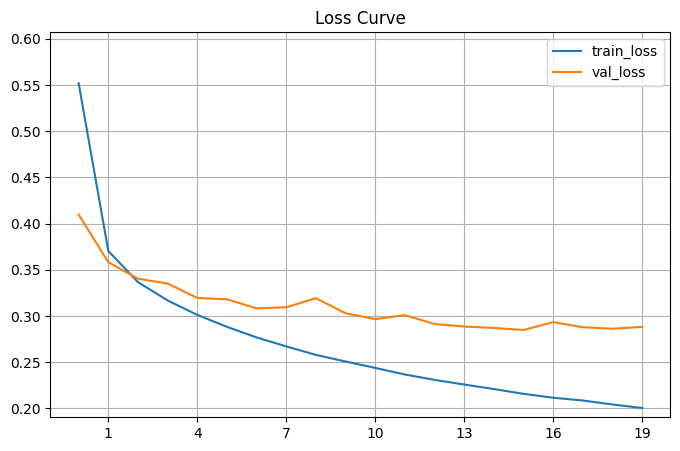

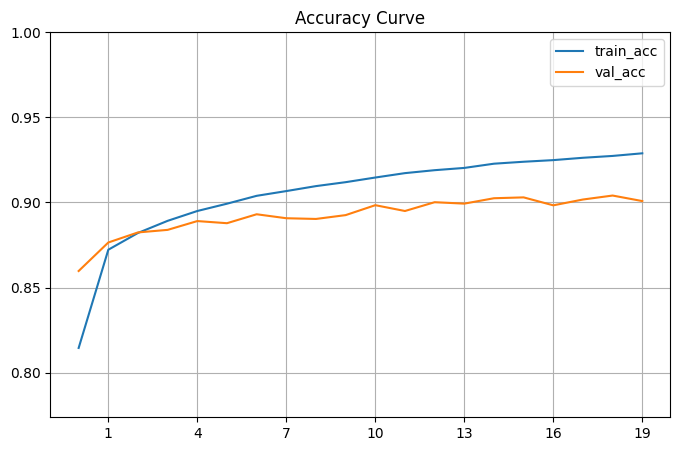

In [ ]:
clf = cnn1(in_channels=in_channels, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):

        # reshape the images to proper shape
        batch_size = images.shape[0]

        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)

        # back prop
        optimizer.zero_grad()
        loss.backward()

        # update model params
        optimizer.step()

        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()

    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples

    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0
    correct = 0
    for images, targets in val_loader:
        batch_size = images.shape[0]
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    # print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")

    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)

clf.eval()
test_loss = 0.0
num_test_samples = 0
correct = 0
for images, targets in test_loader:
    batch_size = images.shape[0]
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

train_state_df = pd.DataFrame(train_state)
# print(train_state_df.round(3))
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")

## b. Add another convolutional layer and pool layer to your current model. Do you notice any difference between these two CNN models?

In [ ]:
class cnn2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(cnn2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=12, kernel_size=3)
        self.conv2 = nn.Conv2d(12, 48, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(48 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #（1,28,28）->(12,26,26)
        x = self.pool(x) #(12,26,26)->(12,13,13)
        x = F.relu(self.conv2(x)) #（12,13,13）->(48,10,10)
        x = self.pool(x) #(48,10,10)->(48,5,5)
        x = x.view(-1, 48 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
x = torch.randn(64, 1, 28, 28) # fake data with the same shape as batch input
model = cnn2(in_channels=1, num_classes=10)
out = model(x)
print(out.shape)

torch.Size([64, 10])


testing loss: 0.325, testing accuracy: 91.230%


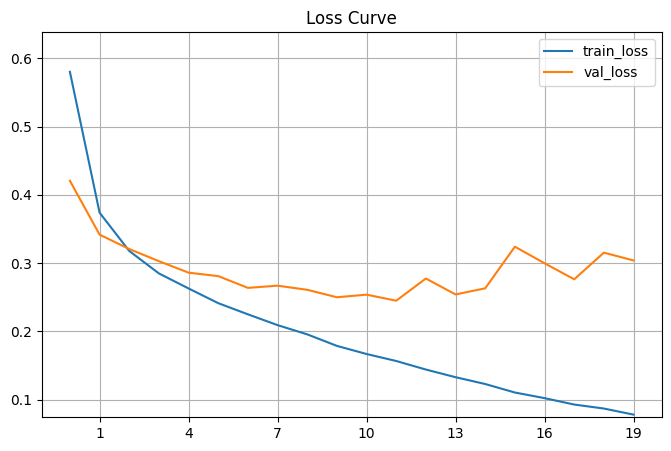

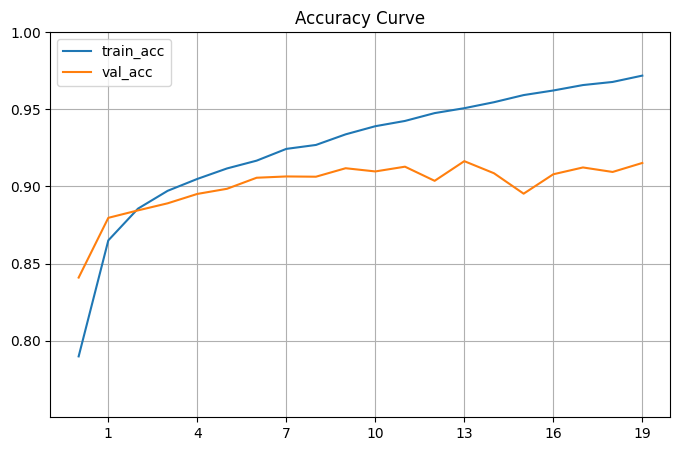

In [66]:
clf = cnn2(in_channels=in_channels, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):

        # reshape the images to proper shape
        batch_size = images.shape[0]

        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)

        # back prop
        optimizer.zero_grad()
        loss.backward()

        # update model params
        optimizer.step()

        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()

    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples

    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0
    correct = 0
    for images, targets in val_loader:
        batch_size = images.shape[0]
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    # print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")

    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)

clf.eval()
test_loss = 0.0
num_test_samples = 0
correct = 0
for images, targets in test_loader:
    batch_size = images.shape[0]
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")

train_state_df = pd.DataFrame(train_state)
# print(train_state_df.round(3))
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")

The second CNN have higher test accuracy, but tends to overfitting.

## c. Do you observe any improvement for the evaluation result compared to problem 2? Why does convolutional neural network have advantages over feedforward fully connected neural network in this task (Please state at least two reasons)

Yes, the test accuracy is higher, the loss is lower and the model is still underfitting with the same number of epoch in the CNN compared with FCNN.

CNN connect and share parameters to reduce workload, which makes it quicker.
Plus, CNN could break down images into simple pieces and put them together to recognize complex stuff, making them great at handling different angles and sizes of objects in images.